This workbook is continuing work from michaelis_m_eq workbook2 but will try to clean some data to make the 170 parameter a little more consistent or add continuity.

#### I surmise that there might be 3 problems:
1-beginning of runs sharp decresaes in HR because i'm not acugtally running
2-end of runs sharp increases in HR because i sprinted or did somethign silly
3-generally too much variation that I don't need for htis model

This workbook tries to remedy or put little band-aids over these problems to get more continutity in 170 parameter.

In [1]:
#change width of current notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:


import json
import datetime
from datetime import timedelta
import os, zipfile
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_zip_med=r"C:\Users\captian2020\Downloads\polar-user-data-export_6103854c-9559-4056-8b5d-89feb507be70.zip"
polar_zip=zipfile.ZipFile(data_zip_med)

#read all files in zip to dictionary of file names and json (each value is a training_session)
polar_data_dict={}
for i in polar_zip.filelist:
    polar_data_dict[i.filename]=json.loads(polar_zip.read(i.filename))

#read all training sessions into df's inside of a dict
polar_df_dict={}
for i,j in polar_data_dict.items():
    if 'training-session-' in i:
        var_datetime_utc=j['timeZoneOffset']
        var_datetime_utc_list=[datetime.datetime.strptime(
            k['dateTime']  ,'%Y-%m-%dT%H:%M:%S.%f') + timedelta(
                minutes=var_datetime_utc) for k in j['exercises'][0]['samples']['heartRate']]
        var_values_list=[k['value'] for k in j['exercises'][0]['samples']['heartRate']]
        df=pd.DataFrame(list(zip(var_datetime_utc_list,var_values_list)), columns=[
            'var_datetime_utc','var_value'])
        df['var_activity']=j['name']
        df['var_periodicity']='seconds'
        df['var_type']='heart rate'
        df['var_unit']='heart rate per second'
        df['user_id']=1
        df['source_filename']=i
        df['time_stamp_utc']=datetime.datetime.utcnow()
        df['var_timezone_utc_delta_in_mins']=var_datetime_utc
        polar_df_dict[i]=df

#Dictionary of name, exercise, max obs_y, count
polar_data_dict_abbrev={}
for i,j in polar_df_dict.items():
    polar_data_dict_abbrev[i]=(i,j.at[0,'var_activity'],j.var_value.max(), len(j))

In [3]:
#The model set to max heartrate = 185
def michaelis_m_eq_fixMax(time_var, shape_var):
    return (185 *time_var)/(shape_var + time_var)
def michaelis_m_eq(time_var, shape_var,max_var):
    return (max_var *time_var)/(shape_var + time_var)
#The model set to max heartrate = 170
def michaelis_m_eq_fix170(time_var, shape_var):
    return (170 *time_var)/(shape_var + time_var)
#The model set to max heartrate = 160
def michaelis_m_eq_fix160(time_var, shape_var):
    return (160 *time_var)/(shape_var + time_var)
#The model set to max heartrate = 140
def michaelis_m_eq_fix140(time_var, shape_var):
    return (140 *time_var)/(shape_var + time_var)

In [4]:
def calc_rsq(obs_y, pred_y):
    residuals = obs_y - pred_y
    ss_res=np.sum(residuals**2)
    ss_tot=np.sum((obs_y-np.mean(obs_y))**2)
    r_squared=1-(ss_res/ss_tot)
    return r_squared

In [ ]:
## Here is where I take a stab at fixing #1 and #2.

In [5]:
polar_obs_var_dict={}
polar_pred_var_dict={}
polar_parameters_dict={}
polar_rsq_dict={};first_30_HR_readings_dict={};last_30_HR_readings_dict={}
for a,b in polar_df_dict.items():
    #Get Observed x and y
    var_datetime_utc_list=polar_df_dict[a].var_datetime_utc.to_list()
    obs_x=np.array([(i-var_datetime_utc_list[0]).total_seconds() for i in var_datetime_utc_list])
    obs_y=np.array(polar_df_dict[a].var_value.to_list())
    #calculate parameter for each model
    popt, pcov = curve_fit(michaelis_m_eq, obs_x, obs_y,bounds=(0,np.inf))
    popt_fixMax, pcov_fixMax = curve_fit(michaelis_m_eq_fixMax, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix170, pcov_fix170 = curve_fit(michaelis_m_eq_fix170, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix160, pcov_fix160 = curve_fit(michaelis_m_eq_fix160, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix140, pcov_fix140 = curve_fit(michaelis_m_eq_fix140, obs_x, obs_y,bounds=(0,np.inf))
    #calculated predicted Y's for each model
    pred_y=[michaelis_m_eq(i, popt[0], popt[1]) for i in obs_x]
    pred_y_fixMax=[michaelis_m_eq_fixMax(i, popt_fixMax[0]) for i in obs_x]
    pred_y_fix170=[michaelis_m_eq_fix170(i, popt_fix170[0]) for i in obs_x]
    pred_y_fix160=[michaelis_m_eq_fix160(i, popt_fix160[0]) for i in obs_x]
    pred_y_fix140=[michaelis_m_eq_fix140(i, popt_fix140[0]) for i in obs_x]
    #claculate the r square for each model
    rsq_popt=calc_rsq(obs_y, pred_y)
    rsq_fixMax=calc_rsq(obs_y, pred_y_fixMax)
    rsq_fix170=calc_rsq(obs_y, pred_y_fix170)
    rsq_fix160=calc_rsq(obs_y, pred_y_fix160)
    rsq_fix140=calc_rsq(obs_y, pred_y_fix140)
        
    #make dictionary's for readings
    polar_obs_var_dict[a]=(obs_x, obs_y)
    polar_pred_var_dict[a]=(pred_y,pred_y_fixMax, pred_y_fix170, pred_y_fix160, pred_y_fix140)
    polar_parameters_dict[a]=(popt, popt_fixMax[0], popt_fix170[0], popt_fix160[0], popt_fix140[0])
    polar_rsq_dict[a]=(rsq_popt, rsq_fixMax, rsq_fix170, rsq_fix160, rsq_fix140)
    first_30_HR_readings_dict[a]=obs_y[:30]#get first 30 HR's for each run
    last_30_HR_readings_dict[a]=obs_y[-30:]#get last 30 HR's for each run

In [13]:
df_description = pd.DataFrame.from_dict(polar_data_dict_abbrev, orient='index', columns=['name', 'exercise', 'maxObs_y', 'count'])
df_parameters = pd.DataFrame.from_dict(polar_parameters_dict, orient='index', columns=['popt', 'popt_fixMax', 'popt_fix170', 'popt_fix160', 'popt_fix140'])
df_rsq=pd.DataFrame.from_dict(polar_rsq_dict, orient='index', columns=['rsq_popt', 'rsq_fixMax', 'rsq_fix170', 'rsq_fix160', 'rsq_fix140'])

#Make excel spreadsheet with polar_data_dict_abbrev | df_parameters | df_rsq
frames=[df_description, df_parameters,df_rsq]
result_primary=pd.concat(frames, axis=1)
result_primary.to_excel('big_table5.xlsx', index=False)

In [11]:
df_first_readings=pd.DataFrame.from_dict(first_30_HR_readings_dict, orient='index')
frames=[df_description, df_first_readings]
result=pd.concat(frames, axis=1)
result.to_excel('first_30_HR_readings_dict.xlsx', index=False)

df_last_readings=pd.DataFrame.from_dict(last_30_HR_readings_dict, orient='index')
frames=[df_description, df_last_readings]
result=pd.concat(frames, axis=1)
result.to_excel('last_30_HR_readings_dict.xlsx', index=False)

Consider training-session-2021-06-07-6130417624-09066edd-885a-499d-8f5a-80a28a736dc9.json
If we remove the beginnig where the data dips do we get a better fit?

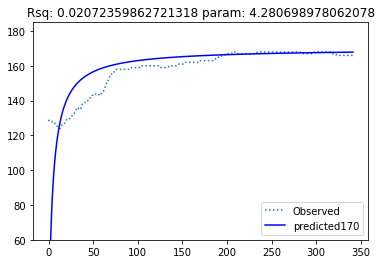

In [60]:
training_session='training-session-2021-05-05-6002663974-0f4e42e9-7513-4263-84cd-1b694b1500eb.json'
obs_x_y=polar_obs_var_dict[training_session]
predicted_y=polar_pred_var_dict[training_session]

plt.plot(obs_x_y[0], obs_x_y[1],':', label='Observed')
plt.plot(obs_x_y[0],predicted_y[2],'b-', label='predicted170')
rsq_plot=polar_rsq_dict[training_session][2];popt_fix170_plot=polar_parameters_dict[training_session][2]
plt.title(f"Rsq: {rsq_plot} param: {popt_fix170_plot}")
plt.legend(loc='best')
plt.ylim([60, 185])
plt.show()

In [57]:
# result_primary.at[0,['popt_fix170', 'rsq_fix170']]
# result_primary.loc[1:2, result_primary.columns.isin(['popt_fix170', 'rsq_fix170'])]

# result_small_170=result_primary[['name' ,'exercise', 'maxObs_y' ,'count' ,'popt_fix170', 'rsq_fix170']].copy()
result_small_170.loc[training_session,:]

name           training-session-2021-05-05-6002663974-0f4e42e...
exercise                                                 Running
maxObs_y                                                     168
count                                                        342
popt_fix170                                             4.280699
rsq_fix170                                              0.020724
Name: training-session-2021-05-05-6002663974-0f4e42e9-7513-4263-84cd-1b694b1500eb.json, dtype: object

In [54]:
cutoff=11
x_run_test=np.array(range(0,len(polar_obs_var_dict[training_session][0][cutoff:])))
y_run_test=polar_obs_var_dict[training_session][1][cutoff:]

popt_fix170, pcov_fix170 = curve_fit(michaelis_m_eq_fix170, x_run_test, y_run_test,bounds=(0,np.inf))

pred_y_fix170=[michaelis_m_eq_fix170(i, popt_fix170[0]) for i in x_run_test]

rsq_fix170=calc_rsq(y_run_test, pred_y_fix170)

print(popt_fix170,rsq_fix170)

[7.80409008] 0.23749375115010707


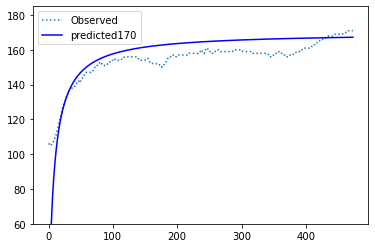

In [55]:
obs_x_y=(x_run_test,y_run_test)
predicted_y=pred_y_fix170

plt.plot(obs_x_y[0], obs_x_y[1],':', label='Observed')
plt.plot(obs_x_y[0],predicted_y,'b-', label='predicted170')
# plt.plot(obs_x_y[0],predicted_y[0],'r-', label='predicted')
plt.legend(loc='best')
plt.ylim([60, 185])
plt.show()

build a def for chart
input: obs_x, obs_y, pred_y, rsq, param
output: -chart w/ obs_y and pred_y
-title with rsq, param, count

In [153]:
def plot_build(obs_x, obs_y, pred_y, rsq, param):
    plt.plot(obs_x, obs_y,':', label='Observed')
    plt.plot(obs_x,pred_y,'b-', label='predicted170')
    plt.legend(loc=4)
    plt.ylim([60, 185])
    plt.title("count:{len(obs_x)} /n rsq:{rsq:.3g} /n param:{param:3g}",x=0.4, y=0.9)
    

In [ ]:
training_session='training-session-2021-05-05-6002663974-0f4e42e9-7513-4263-84cd-1b694b1500eb.json'
obs_x=polar_obs_var_dict[training_session][0]; obs_y=polar_obs_var_dict[training_session][1]
popt_fix170, pcov_fix170 = curve_fit(michaelis_m_eq_fix170, x_run_test, y_run_test,bounds=(0,np.inf))
predicted_y=polar_pred_var_dict[training_session]
